# Port Congestion (Live-Historical)

This example provides information about the live & historical number of vessels waiting for operation or operating in a selected Port.

## Setup
Install the Signal Ocean SDK:
```
pip install signal-ocean
```
Set your subscription key acquired here: https://apis.signalocean.com/profile

In [1]:
# pip install signal-ocean

In [2]:
signal_ocean_api_key = ""  # replace with your subscription key

## Live

In order to access the port congestion of a specific port (in this case Rotterdam) we are going to use the voyages data api.  
More specifically we are going to retrieve the voyages events of MR2 vessels for the last 4 months and then use the available data regarding **event_horizon**, **arrival_date** and **sailing_date** in order to find out what vessels are operating or are expecting to operate at the port of interest.  
   
The time window of four months and also the narrowing of the vessel classes to one are used to restrict the data load of the api call and hence the running time of the notebook. For a more extended investigation the user is prompt to store locally the full voyages data of his interest and then run the analysis using them. This example displays a way to achieve this through sqlite.

In [3]:
from signal_ocean import Connection
from signal_ocean.voyages import VoyagesAPI

import pandas as pd
from datetime import date, datetime, timedelta
import sqlite3

In [4]:
connection = Connection(signal_ocean_api_key)
api = VoyagesAPI(connection)

In [5]:
mr2_id = 88
date_from = date.today() - timedelta(days=120)
recent_mr2_voyages_flat = api.get_voyages_flat(
    vessel_class_id=mr2_id, date_from=date_from
)

In [6]:
mr2_voyages_df = pd.DataFrame(v.__dict__ for v in recent_mr2_voyages_flat.voyages)
mr2_events_df = pd.DataFrame(v.__dict__ for v in recent_mr2_voyages_flat.events)
mr2_events_details_df = pd.DataFrame(
    v.__dict__ for v in recent_mr2_voyages_flat.event_details
)

In [7]:
# the first time the connection is created, the .db file is created as well
conn = sqlite3.connect("port_congestion.db")

In [8]:
from sqlalchemy import types, create_engine
from os import path
import os

# we create an sqlalchemy engine for the db that we have created
engine = create_engine(
    f'sqlite:///{path.join(os.path.abspath(os.getcwd()), "port_congestion.db")}'
)

# create tables and append the data
mr2_voyages_df.to_sql("mr2_voyages", engine, index=True, if_exists="replace")
mr2_events_df.to_sql("mr2_events", engine, index=True, if_exists="replace")
mr2_events_details_df.to_sql(
    "mr2_events_details", engine, index=True, if_exists="replace"
)

In [9]:
relative_events_query = """
    select 
    imo,
    vessel_name,
    commercial_operator,
    voyage_number,
    ev.id,
    event_type,
    event_horizon,
    purpose,
    date(ev.arrival_date) as arrival_date,
    date(ev.sailing_date) as sailing_date,
    start_time_of_operation
    from mr2_voyages voy 
    left join mr2_events ev on ev.voyage_id = voy.id
    left join mr2_events_details det on det.event_id = ev.id
    where
     (
         (event_horizon = 'Current' and Date(ev.sailing_date) >= Date('now'))
         or 
         (event_horizon = 'Future' and Date(ev.arrival_date) <= Date('now'))
         or
        (event_horizon = 'Historical' and Date(ev.sailing_date) = Date('now'))
    )
    and not (ev.event_horizon = 'Future' and Date(ev.sailing_date)  < Date('now') )
    and event_type in ('PortCall', 'Stop')
    and port_name = 'Rotterdam'
    and purpose in ('Load', 'Discharge', 'Stop')
"""

In [10]:
relative_events_df = pd.read_sql_query(
    relative_events_query, 
    conn, 
    parse_dates = ['arrival_date','sailing_date','start_time_of_operation']
)

In [11]:
def set_status(row):
    if row.event_horizon == 'Historical' and row.purpose != "Stop":
        return 'Sailed' + row.purpose
    elif row.purpose == "Stop":
        return "Stop"
    elif row.event_horizon == 'Future':
        if row.sailing_date.date() <= date.today() or row.arrival_date.date() < date.today():
            return "No Position Updates"
        elif row.sailing_date.date() > date.today():
            return 'Expected to ' + row.purpose
    elif row.event_horizon == 'Current':
        if row.start_time_of_operation > datetime.now():
            return "Expected to" + row.purpose
        elif row.start_time_of_operation < datetime.now():
            return "Operating (" + row.purpose + ")"
        elif row.arrival_date.date() <= date.today() <=  row.sailing_date.date():
            return "Operating (" + row.purpose + ")"
    else:
        return "UNK"

In [12]:
live_port_congestion_df = (
    relative_events_df
    .sort_values(
        ['arrival_date','start_time_of_operation'],
        ascending = [False,False]
    )
    .groupby(
        ["imo","voyage_number","event_type"]
    )
    .first()
    .reset_index()
)

In [13]:
live_port_congestion_df['Status'] = live_port_congestion_df.apply(set_status,axis=1)

In [14]:
live_port_congestion_df.drop(
    ['voyage_number','event_type','id','start_time_of_operation']
    ,axis=1
    ,inplace=True
)

In [15]:
live_port_congestion_df

,imo,vessel_name,commercial_operator,event_horizon,purpose,arrival_date,sailing_date,Status
0,9215309,Bow Saga,Odfjell,Current,Discharge,2021-08-24,2021-08-27,Operating (Discharge)
1,9273351,Eternal Sunshine,Product Shipping & Trading,Historical,Stop,2021-08-17,2021-08-25,Stop
2,9405928,Pine Express,Maersk,Current,Discharge,2021-08-21,2021-08-26,Operating (Discharge)
3,9407392,Horizon Theano,Horizon Tankers,Current,Discharge,2021-08-23,2021-08-26,Operating (Discharge)
4,9466013,Torm Agnete,Torm,Current,Discharge,2021-08-23,2021-08-28,Operating (Discharge)
5,9635755,Valle Luna,Vitol,Historical,Stop,2021-08-20,2021-08-25,Stop
6,9708203,Ardmore Sealion,Ardmore Shipping,Historical,Stop,2021-08-23,2021-08-25,Stop
7,9718430,Silver Etrema,Shell,Current,Discharge,2021-08-24,2021-08-26,Operating (Discharge)


## Historical

In [16]:
from signal_ocean import Connection
from signal_ocean.voyages import VoyagesAPI

import pandas as pd
from datetime import date, timedelta
import sqlite3

In [17]:
connection = Connection(signal_ocean_api_key)
api = VoyagesAPI(connection)

We get the MR2 voyages that have started during the last year.  
Since we need historical port congestion info there is no way to avoid making a heavy call on voyages data api.

In [18]:
%%time

mr2_id = 88
date_from = date.today() - timedelta(days=365)
recent_mr2_voyages_flat = api.get_voyages_flat(
    vessel_class_id=mr2_id, date_from=date_from
)

Wall time: 2min 16s


In [19]:
mr2_voyages_df = pd.DataFrame(v.__dict__ for v in recent_mr2_voyages_flat.voyages)
mr2_events_df = pd.DataFrame(v.__dict__ for v in recent_mr2_voyages_flat.events)

In [20]:
rotterdam_events = mr2_events_df[
    (mr2_events_df.port_name == "Rotterdam")
    & (mr2_events_df.purpose.isin(["Discharge", "Load", "Stop"]))
    & (mr2_events_df.arrival_date.apply(lambda x: x.date()) <= date.today())
].copy()

In [21]:
rotterdam_events["imo"] = rotterdam_events.voyage_id.map(
    dict(zip(mr2_voyages_df.id, mr2_voyages_df.imo))
)

**in_port** column stores the date range between arrival and sailing data. By exploding the dataframe based on this column we get one row per date inside the date range. This is used later on the aggregations.

In [22]:
rotterdam_events["in_port"] = rotterdam_events.apply(
    lambda row: pd.date_range(row.arrival_date.date(), row.sailing_date.date()), axis=1
)

In [23]:
rotterdam_events_ext = rotterdam_events.explode("in_port")

In [24]:
num_of_vessels_time_series = (
    rotterdam_events_ext.groupby("in_port")["imo"].nunique().reset_index()
)
num_of_vessels_time_series.columns = ["date", "vessels"]

**date_range_basis** dictates the dates to be displayed on the graph. On top of that ensures the continuity of the time series data by assigning 0 to the dates that had no vessels waiting or operating at the port of interest.

In [25]:
date_range_basis = pd.date_range(
    start=date(2021,1,1),
    end=date.today(),
)

In [26]:
num_of_vessels_time_series = (
num_of_vessels_time_series
    .set_index("date")
    .reindex(date_range_basis)
    .fillna(0.0)
    .rename_axis("date").reset_index()
)

In [27]:
from matplotlib import pyplot as plt
import seaborn as sns

<AxesSubplot:xlabel='date', ylabel='vessels'>

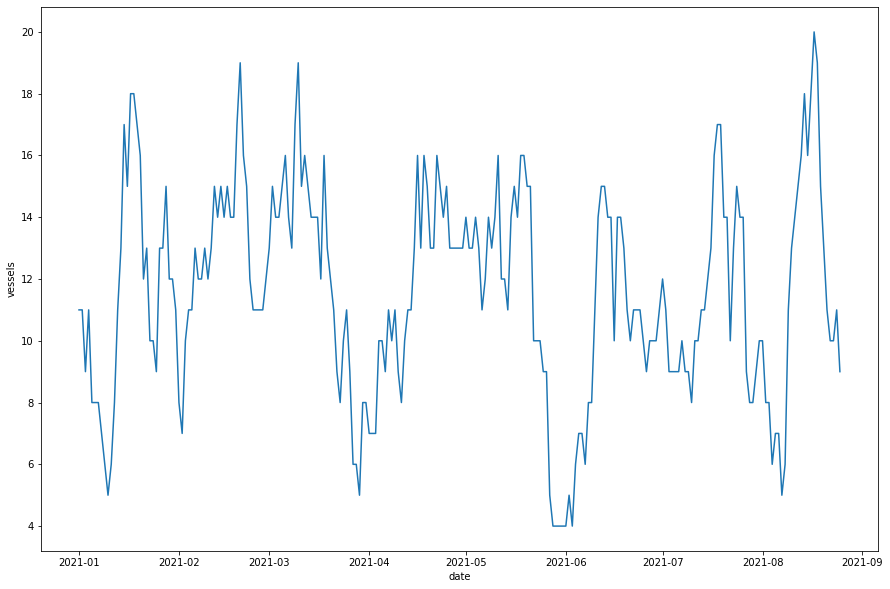

In [28]:
fig,ax = plt.subplots(figsize = (15,10))

sns.lineplot(data=num_of_vessels_time_series, x="date", y="vessels")